In [39]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe

import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

import eurostat

In [40]:
m = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

In [102]:
gdp = eurostat.get_data_df('namq_10_gdp')
gdp = gdp[gdp['geo\\time'].str.match('FI') & gdp['unit'].str.match('CP_MEUR') & gdp['s_adj'].str.match('NSA') & gdp['na_item'].str.match('B1GQ')]
gdp = gdp.drop(gdp.columns[:4], axis=1).dropna(axis=1).iloc[:,::-1]
gdp = gdp.drop(gdp.columns[:list(gdp.columns).index('2000Q1')], axis=1)
gdp.index = ['gdp']
gdp

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
gdp,31770.0,33827.0,34062.0,36783.0,34472.0,36331.0,35933.0,37892.0,34994.0,37641.0,...,55783.0,58896.0,57846.0,61139.0,57243.0,60914.0,59873.0,62526.0,57542.0,57965.0


In [103]:
ue_df = eurostat.get_data_df('tipsun30')
ue_df = ue_df[ue_df['geo\\time'].str.match('FI')]
ue_df = ue_df.drop(ue_df.columns[:5], axis=1).dropna(axis=1)
ue_df = ue_df.drop(ue_df.columns[:list(ue_df.columns).index('2000Q1')], axis=1)
ue_df.index = ['une']
ue_df.head()

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
une,10.5,9.8,9.5,9.4,9.3,9.0,9.1,9.1,9.1,9.1,...,8.3,7.2,7.2,6.7,6.7,6.6,6.8,6.8,6.8,7.7


In [104]:
EMU_conv_df = eurostat.get_data_df('irt_lt_mcby_q')
EMU_conv_df = EMU_conv_df[EMU_conv_df['geo\\time'].str.match('FI')]
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:3], axis=1).iloc[:,::-1].dropna(axis=1)
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:list(EMU_conv_df.columns).index('2000Q1')], axis=1)
EMU_conv_df.index = ['int']
EMU_conv_df.head()

,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
int,5.66,5.48,5.47,5.33,4.99,5.22,5.13,4.83,5.16,5.33,...,0.74,0.67,0.58,0.65,0.41,0.21,-0.25,-0.11,-0.14,-0.09


In [108]:
cpi = eurostat.get_data_df('ei_cphi_m')
cpi = cpi[cpi['geo\\time'].str.match('FI') & cpi['indic'].str.match('CP-HI00')]
cpi = cpi.drop(cpi.index[1:])
cpi = cpi.drop(cpi.columns[:4], axis=1).dropna(axis=1).iloc[:, ::-1]
cpi = cpi.drop(cpi.columns[:list(cpi.columns).index('2000M01')], axis=1)
cpi.index = ['cpi']
cpi.head()

,2000M01,2000M02,2000M03,2000M04,2000M05,2000M06,2000M07,2000M08,2000M09,2000M10,...,2020M01,2020M02,2020M03,2020M04,2020M05,2020M06,2020M07,2020M08,2020M09,2020M10
cpi,75.22,75.8,76.3,76.44,76.8,77.09,76.73,76.8,77.59,77.66,...,103.72,104.2,104.03,103.58,103.52,103.77,104.07,104.09,104.11,104.23


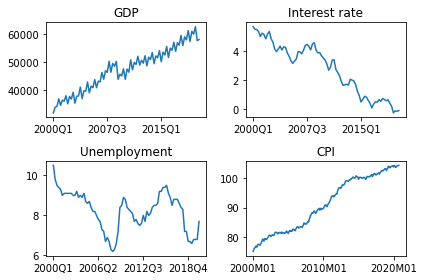

In [110]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(gdp.iloc[0])
axs[0,0].set_xticks([i for e, i in enumerate(gdp.columns) if e % 30 == 0])
axs[0,0].set_title('GDP')
axs[1,0].plot(ue_df.iloc[0])
axs[1,0].set_title('Unemployment')
axs[1,0].set_xticks([i for e, i in enumerate(ue_df.columns) if e % 25 == 0])
axs[0,1].plot(EMU_conv_df.iloc[0])
axs[0,1].set_title('Interest rate')
axs[0,1].set_xticks([i for e, i in enumerate(EMU_conv_df.columns) if e % 30 == 0])
axs[1,1].plot(cpi.iloc[0])
axs[1,1].set_title('CPI')
axs[1,1].set_xticks([i for e, i in enumerate(cpi.columns) if e % 120 == 0])
fig.tight_layout()

mq_aggregate_df, ue_df, EMU_conv_df, cpi

In [55]:
# mq_aggregate_df, ue_df, EMU_conv_df, cpi
c_gdp, t_gdp = sm.tsa.filters.hpfilter(gdp.iloc[0], 1600)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> dtype('<U21')